<a href="https://colab.research.google.com/github/SPThole/Pytorch-Tutorials/blob/master/lstm_name_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [415]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import dataset, DataLoader

from torch.utils.data import random_split
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split

# Getting Data

In [416]:
df = pd.read_csv('/content/drive/MyDrive/baby_names.csv')
df['len_name'] = df['NAME'].apply(lambda x: len(x))
df['GENDER'] = df['GENDER'].map({'FEMALE':0,'MALE':1})
gender = list(df['GENDER'].values)
names = list(df['NAME'].apply(lambda x: x.lower()).values)
max_len = max(df['len_name'])

# Preprocessing Data

In [429]:

d = {'<SOS>':0,
       '<EOS>':1,
       '<PAD>':2}

In [430]:
def name_to_idx(name,d):
  name1 = name
  for c in name1:
    if c not in list(d.keys()):
      d[c] = max(list(d.values()))+1
  return d

def form_dict(names,d,max_len):
  for n in tqdm(names):
    n1 = input_create(n,max_len)
    d = name_to_idx(n1,d)
  return d

def input_create(name,max_len):
  
  name1 = list(name)
  name1 = name1 + ['<EOS>']
  return name1

def one_hot(c,d):
  one_h = [0 for i in range(len(d))]
  one_h[d[c]] = 1
  return one_h

In [431]:
d = form_dict(names,d,11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [432]:
d

{"'": 29,
 '<EOS>': 1,
 '<PAD>': 2,
 '<SOS>': 0,
 'a': 6,
 'b': 20,
 'c': 12,
 'd': 8,
 'e': 4,
 'f': 24,
 'g': 3,
 'h': 15,
 'i': 9,
 'j': 22,
 'k': 26,
 'l': 7,
 'm': 19,
 'n': 10,
 'o': 25,
 'p': 14,
 'q': 23,
 'r': 5,
 's': 11,
 't': 21,
 'u': 13,
 'v': 18,
 'w': 27,
 'x': 28,
 'y': 16,
 'z': 17}

In [433]:
class mydata(DataLoader):
  
  def __init__(self,names):

    self.names = names

  
  def __getitem__(self,idx):

    name = self.names[idx]
    X = [one_hot(c,d) for c in input_create(name,11)]
    X = torch.tensor(X[:-1]).float()
    Y = torch.tensor([d[s] for s in input_create(name,11)][1:]).float()
    # Y = torch.tensor(X[1:]).float()
    return X,Y

  def __len__(self):
    return len(self.names)


In [434]:
dataset = mydata(names)
train_dataset, test_dataset = random_split(dataset,[10000,3962])
# train_loader = DataLoader(train_dataset,128,drop_last=True)
# test_loader = DataLoader(test_dataset,128,drop_last=True)

In [435]:
len(d)

30

# Model and training

In [436]:
class my_net(nn.Module):

  def __init__(self,input_size,hidden_size,output_size,batch_size,layers):
    super(my_net, self).__init__()
    self.input_size = input_size
    # self.sequence_size = sequence_size
    self.layers = layers
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size

    self.rnn = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       dropout =0.4,
                       num_layers = self.layers,
                       batch_first = True)
    # input = torch.randn(5, 3, 10)
    self.fc = nn.Linear(self.hidden_size, self.output_size)

  def forward(self,x,h0,c0):

    

    out, (h0,c0) = self.rnn(x, (h0, c0))

    # print(out.shape)

    # out = out.reshape(self.batch_size, self.sequence_size, self.hidden_size)
    
    out = self.fc(out)
    return out.squeeze(0),(h0,c0)

In [437]:
model = my_net(30,90,30,1,1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [438]:

# h0 = torch.randn(model.layers, model.batch_size,model.hidden_size)
# c0 = torch.randn(model.layers, model.batch_size,model.hidden_size)
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss()

In [439]:
def trainer_for_name(model,random_int,loss_func,optimizer):

  l = []
  optimizer.zero_grad()
  loss = 0
  h0 = torch.randn(model.layers, model.batch_size,model.hidden_size)
  c0 = torch.randn(model.layers, model.batch_size,model.hidden_size)

  x, y = train_dataset[random_int]
  
  for i in range(x.shape[0]):
    out, (h0,c0) = model(x[i].unsqueeze(0).unsqueeze(0),h0,c0)
    # print(out.shape,y[i].unsqueeze(0).shape)
    loss = loss+loss_func(out,y[i].unsqueeze(0).long())
  
  
  loss.backward()
  optimizer.step()
  return model,loss/x.shape[0]

def training(model,loss_func,optimizer,n=10000):
  LOSS = []
  L = []
  for i in tqdm(range(n)):
    
    random_int = np.random.randint(10000)
    model,loss = trainer_for_name(model,random_int,loss_func,optimizer)
    L.append(loss.item())
    if i%100==0:
        LOSS.append(sum(L)/100)
        L = []
  return model, LOSS





In [440]:
model, LOSS = training(model,loss_func,optimizer,20000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


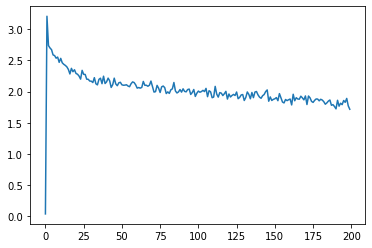

In [441]:
sns.lineplot(np.arange(len(LOSS)),LOSS)

# Generating Names

In [442]:
def sampler(inv_dict,model,start):
  h0 = torch.randn(model.layers, model.batch_size,model.hidden_size)
  c0 = torch.randn(model.layers, model.batch_size,model.hidden_size)
  preds = start
  name = start
  for i in range(100):

    if preds!='<EOS>':
      pred, (h0,c0) = model(mydata(preds)[0][0].unsqueeze(0),h0,c0)
      preds = inv_dict[torch.argmax(pred,axis=1)[0].item()]
      name = name+ preds
  print(name,name in names)






In [443]:
inv_dict = dict(zip(d.values(), d.keys()))

In [446]:
for i in list('abcdefghhijklmnopqrstuvwxyzabcdefghhijklmnopqrstuvwxyz'):
  sampler(inv_dict,model,i)

amila<EOS> False
beris<EOS> False
charles<EOS> False
dariel<EOS> False
ericha<EOS> False
farielle<EOS> False
gaylee<EOS> False
hayler<EOS> False
harian<EOS> False
ijassa<EOS> False
jayler<EOS> False
katherine<EOS> False
liliana<EOS> False
mayler<EOS> False
naylee<EOS> False
orista<EOS> False
peristin<EOS> False
quliel<EOS> False
ratherine<EOS> False
sariel<EOS> False
thariel<EOS> False
ulista<EOS> False
villey<EOS> False
wariel<EOS> False
xilianna<EOS> False
yarles<EOS> False
zariel<EOS> False
alielle<EOS> False
bristan<EOS> False
carlett<EOS> False
darles<EOS> False
elijah<EOS> False
fhandel<EOS> False
garian<EOS> False
hariel<EOS> False
hariel<EOS> False
ianna<EOS> False
jayler<EOS> False
karielle<EOS> False
losha<EOS> False
mayler<EOS> False
nichalle<EOS> False
oricha<EOS> False
parles<EOS> False
quliel<EOS> False
rlistan<EOS> False
saria<EOS> False
telina<EOS> False
uiliana<EOS> False
vaylee<EOS> False
waylee<EOS> False
xarian<EOS> False
yariel<EOS> False
zilley<EOS> False
